<a href="https://colab.research.google.com/github/AshishMoundekar/ML-models.projects/blob/main/FaceMask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Deep learning a model that detects the presence of a face mask in each image.

# Step 1:- Prerequisites

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cloning the YOLOv5 repository and installing dependencies and installing tpdm tqdm for progress bars

In [ ]:
!pip install tqdm

!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (11695/11695), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 23.4 MB/s eta 0:00:00


Loading the data

In [ ]:
dataset_path = '/content/drive/MyDrive/Face_Mask'

# Step 2:- Converting XML to YOLO Format

Importing and installing necessary Libraries

In [ ]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

Creating function to convert labels.xml to yolo suitable file or .txt file


In [ ]:
# Define the class names and assign each class an ID
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']
class_map = {name: idx for idx, name in enumerate(class_names)}

def convert_xml_to_yolo(xml_file, txt_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in class_map:
                print(f"Class {class_name} not found in class_map. Skipping.")
                continue
            class_id = class_map[class_name]

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # Calculate center, width, and height
            x_center = (xmin + xmax) / 2.0 / image_width
            y_center = (ymin + ymax) / 2.0 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            # Ensure the values are between 0 and 1
            x_center = min(max(x_center, 0), 1)
            y_center = min(max(y_center, 0), 1)
            width = min(max(width, 0), 1)
            height = min(max(height, 0), 1)

            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Paths to the dataset
images_dir = '/content/drive/MyDrive/Face_Mask/images'  # Adjust as needed
labels_xml_dir = '/content/drive/MyDrive/Face_Mask/annotations'  # Adjust as needed
# yolo_labels_dir = '/content/drive/MyDrive/Datasets/Face_mask/annotations'

# Directory to save YOLO formatted labels
yolo_labels_dir = 'Face_mask/labels'
os.makedirs(yolo_labels_dir, exist_ok=True)

# Get list of all XML files
xml_files = [f for f in os.listdir(labels_xml_dir) if f.endswith('.xml')]

for xml_file in tqdm(xml_files, desc="Converting XML to YOLO"):
    xml_path = os.path.join(labels_xml_dir, xml_file)
    txt_filename = os.path.splitext(xml_file)[0] + '.txt'
    txt_path = os.path.join(yolo_labels_dir, txt_filename)

    # Parse image size from XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    image_width = float(size.find('width').text)
    image_height = float(size.find('height').text)

    convert_xml_to_yolo(xml_path, txt_path, image_width, image_height)


Converting XML to YOLO: 100%|██████████| 853/853 [00:21<00:00, 40.58it/s] 


# Step 3:- Organizing the Dataset

Making dirs and listing all images in that

In [ ]:
#Create destination dirs
base_dir = 'Face_mask/data'
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# List all image file
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg' ,'.png'))]

Spliting the data in train (70%), val (15%), test (15%).

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

In [ ]:
def copy_files(files, split):
    for file in files:
        # Copy images
        src_image = os.path.join(images_dir, file)
        dst_image = os.path.join(base_dir, split, 'images', file)
        shutil.copy(src_image, dst_image)

        # Copy labels
        label_file = file.split('.')[0] + '.txt'
        src_label = os.path.join(yolo_labels_dir, label_file)
        dst_label = os.path.join(base_dir, split, 'labels', label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)
        else:
            print(f"Label file {src_label} does not exist.")

# Copy files to respective directories
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

Creating the data.yaml File

In [ ]:
# Define class names
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']  # Adjust based on your dataset

# Create data.yaml content
data_yaml_content = f"""
train: {os.path.abspath(os.path.join(base_dir, 'train', 'images'))}
val: {os.path.abspath(os.path.join(base_dir, 'val', 'images'))}
test: {os.path.abspath(os.path.join(base_dir, 'test', 'images'))}

nc: {len(class_names)}
names: {class_names}
"""

# Save data.yaml
with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

# Verify the content
!cat data.yaml


train: /content/yolov5/Face_mask/data/train/images
val: /content/yolov5/Face_mask/data/val/images
test: /content/yolov5/Face_mask/data/test/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']


# Training the model and predicting the image for mask

Training the model YOLOv5 with images and labels

In [ ]:
# Train YOLOv5
!python train.py --img 640 --batch 16 --epochs 50 --data data.yaml --weights yolov5l.pt --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-03 08:07:28.255037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 08:07:28.274769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 08:07:28.280731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

Visualzation the training progression

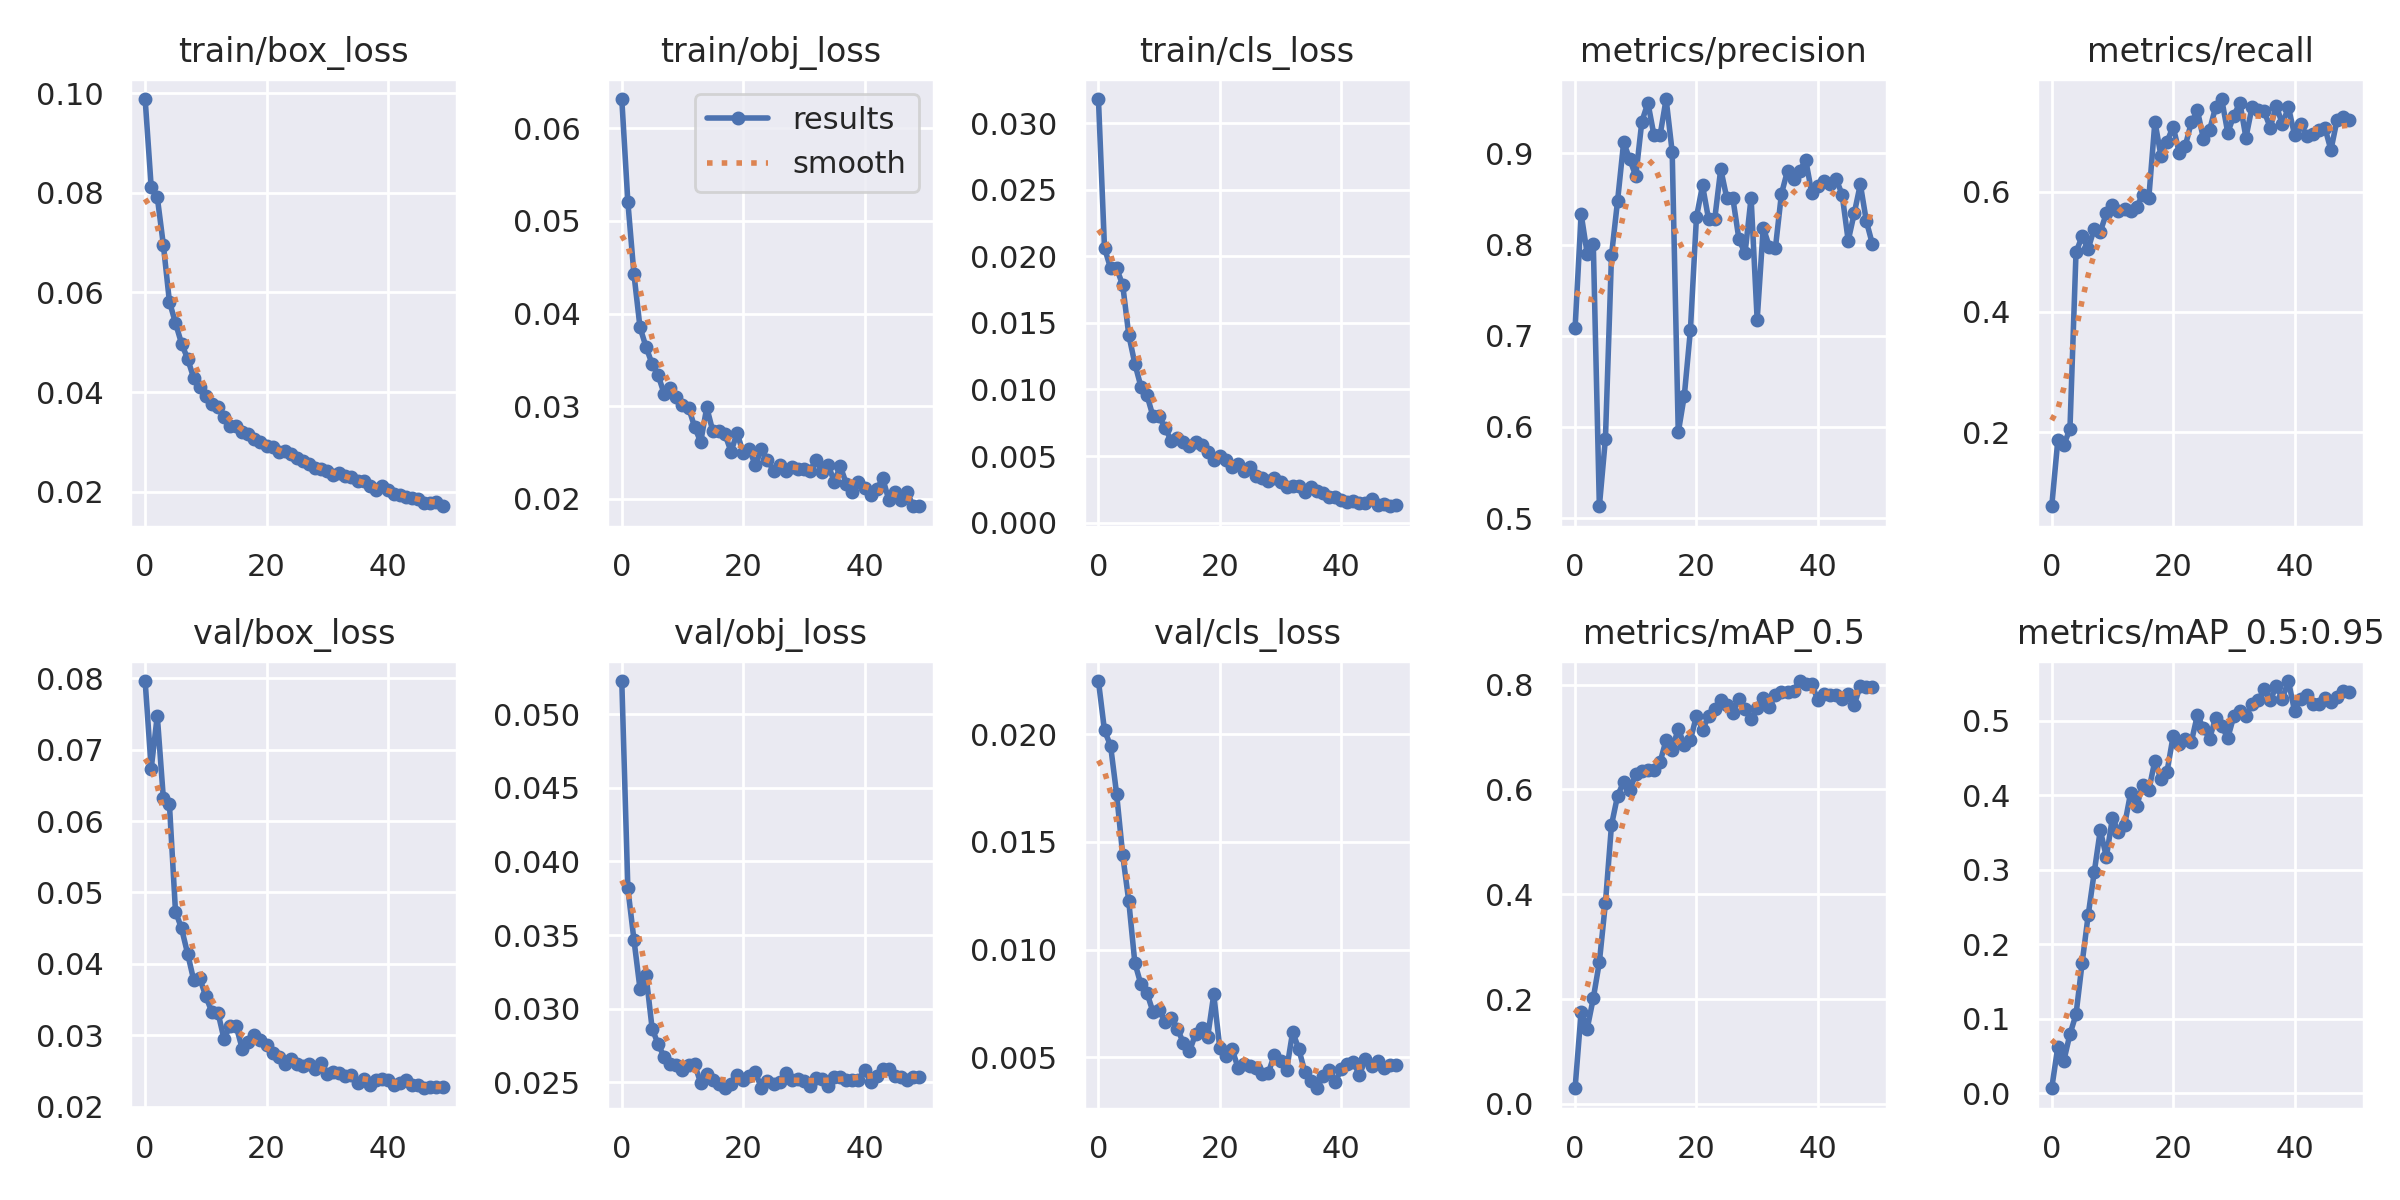

In [ ]:
from IPython.display import Image, display

# Display the training results plot
display(Image(filename='runs/train/exp/results.png'))

Evaluating the Model

In [ ]:
!python val.py --weights runs/train/exp/weights/best.pt --data data.yaml --img 640

val: data=data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /content/yolov5/Face_mask/data/val/labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100% 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:06<00:00,  1.74s/it]
                   all        128        617      0.856      0.741      0.802      0.553
             with_mask        128        497      0.927      0.916      0.955      0.676
 mask_weared_incorrect        128

In [ ]:
# List directories in runs/val
!ls runs/val

exp


In [ ]:
# List contents of each experiment directory
# !ls runs/val/exp
!ls runs/val/exp
# Add more if necessary

confusion_matrix.png  PR_curve.png	     val_batch0_pred.jpg    val_batch2_labels.jpg
F1_curve.png	      R_curve.png	     val_batch1_labels.jpg  val_batch2_pred.jpg
P_curve.png	      val_batch0_labels.jpg  val_batch1_pred.jpg


Visualization the evaluation results

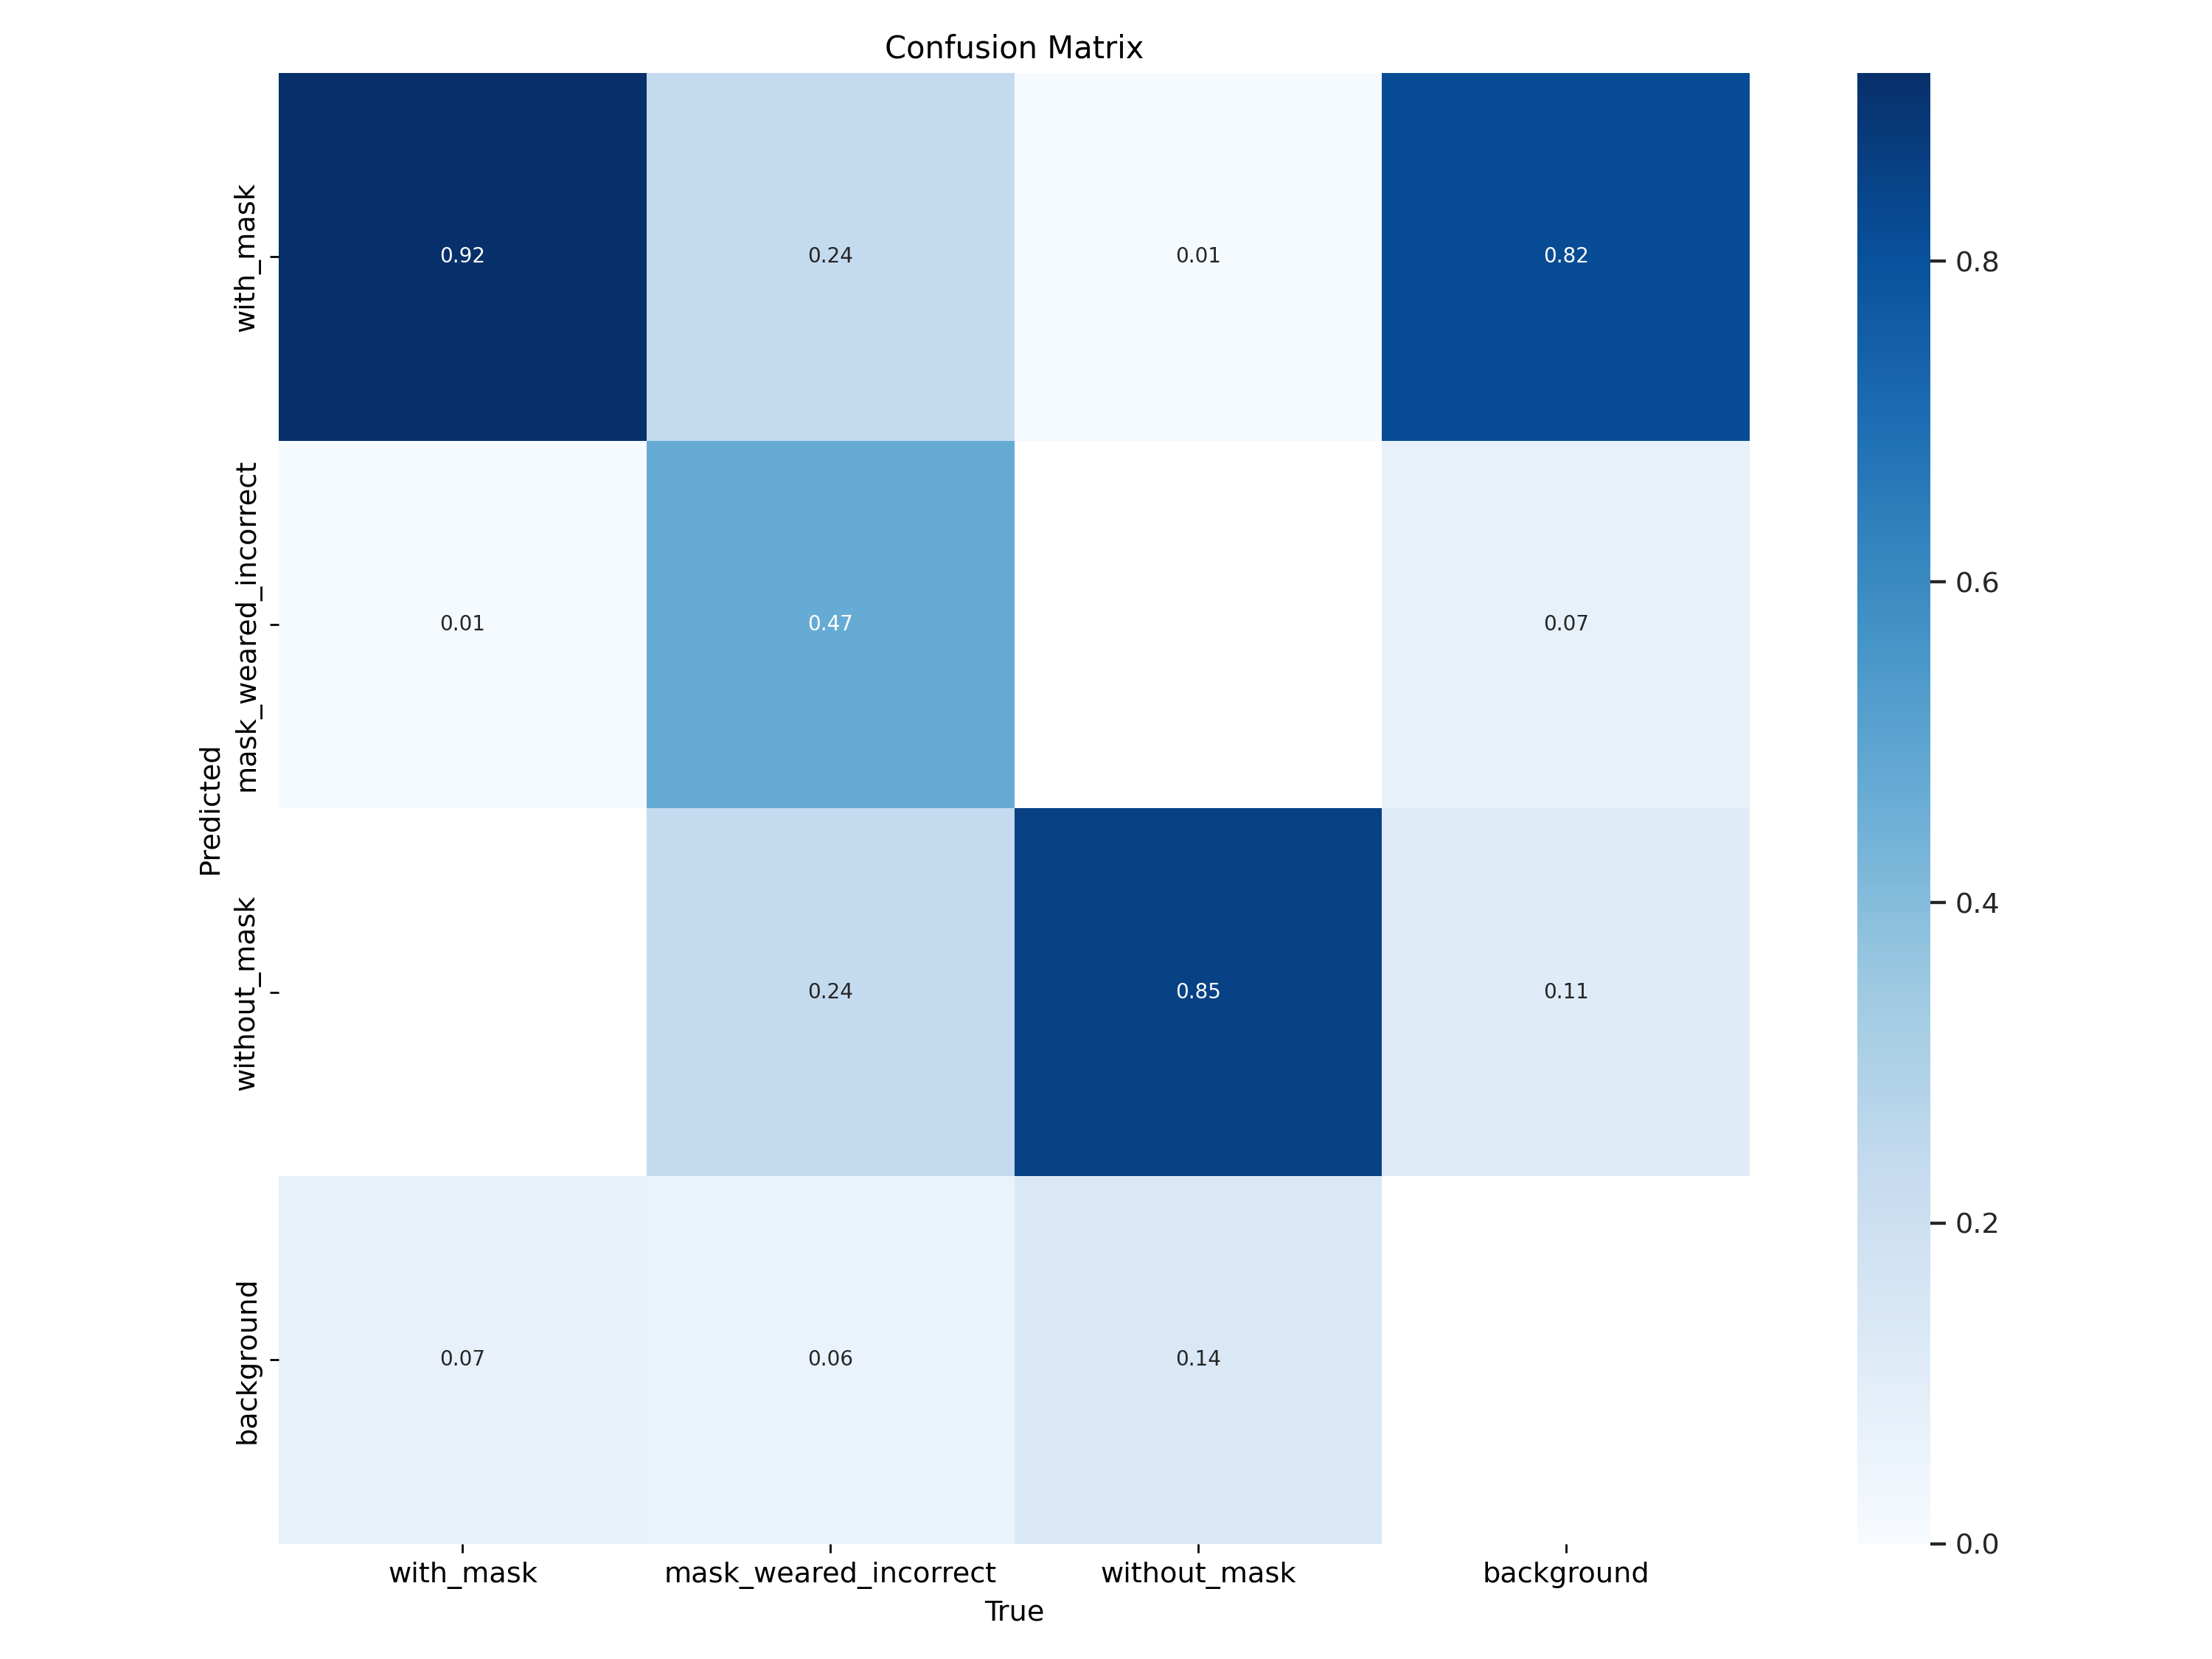

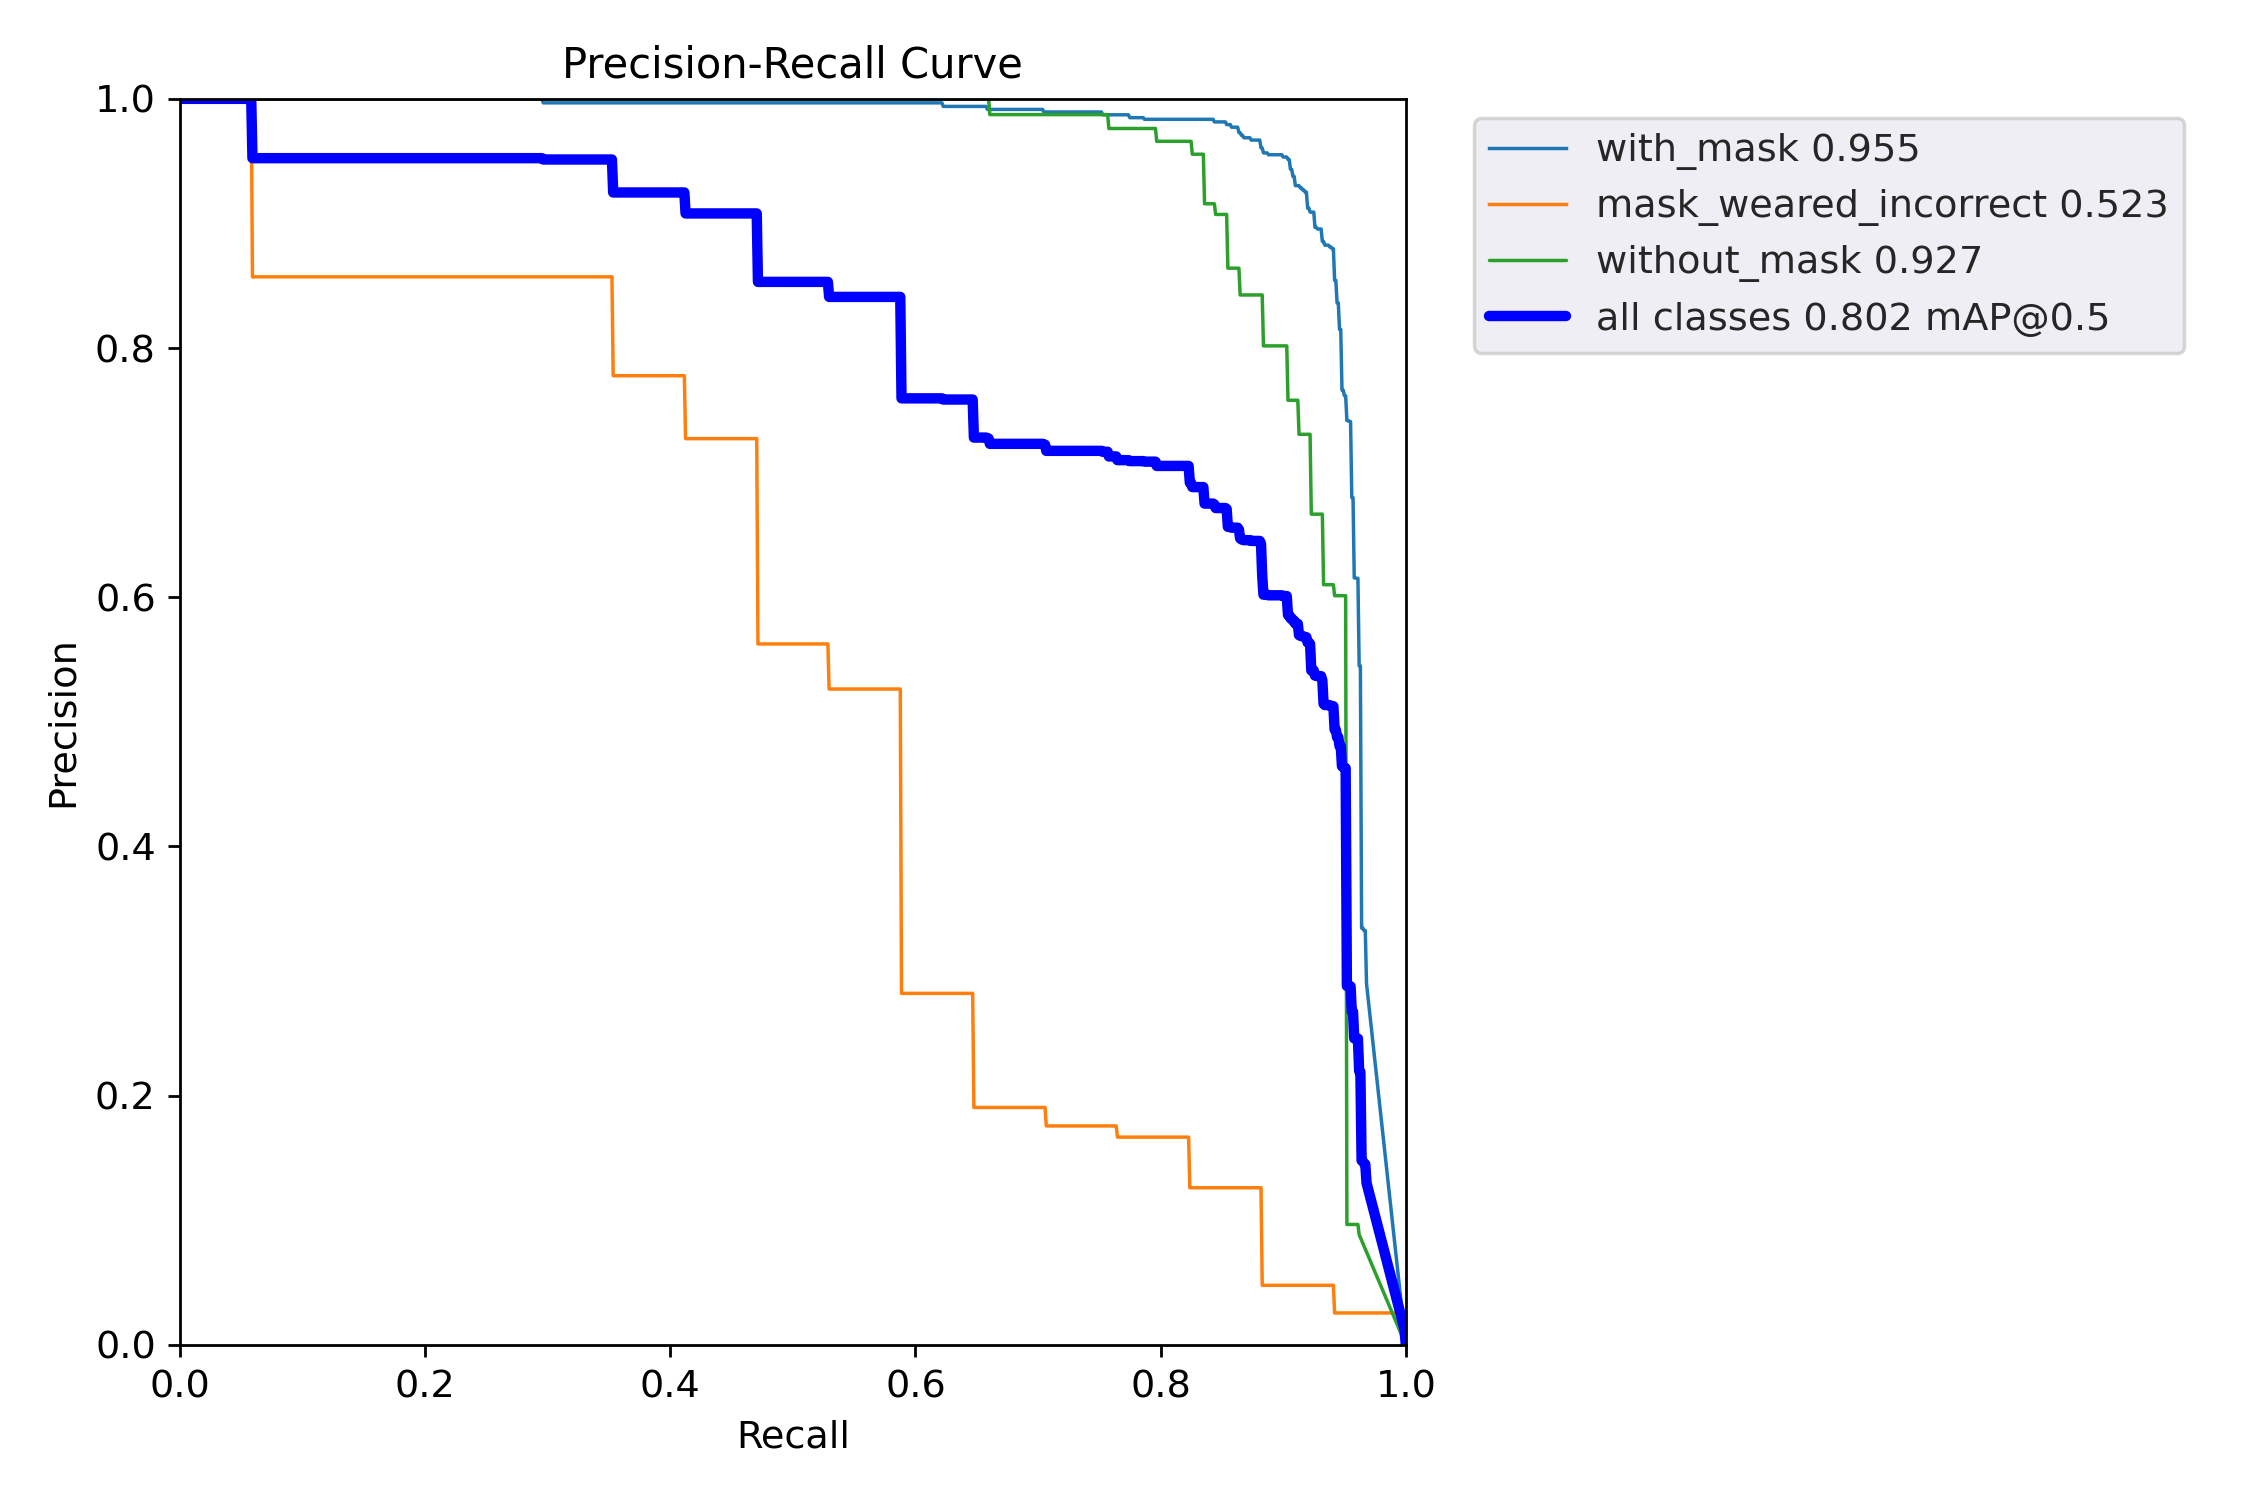

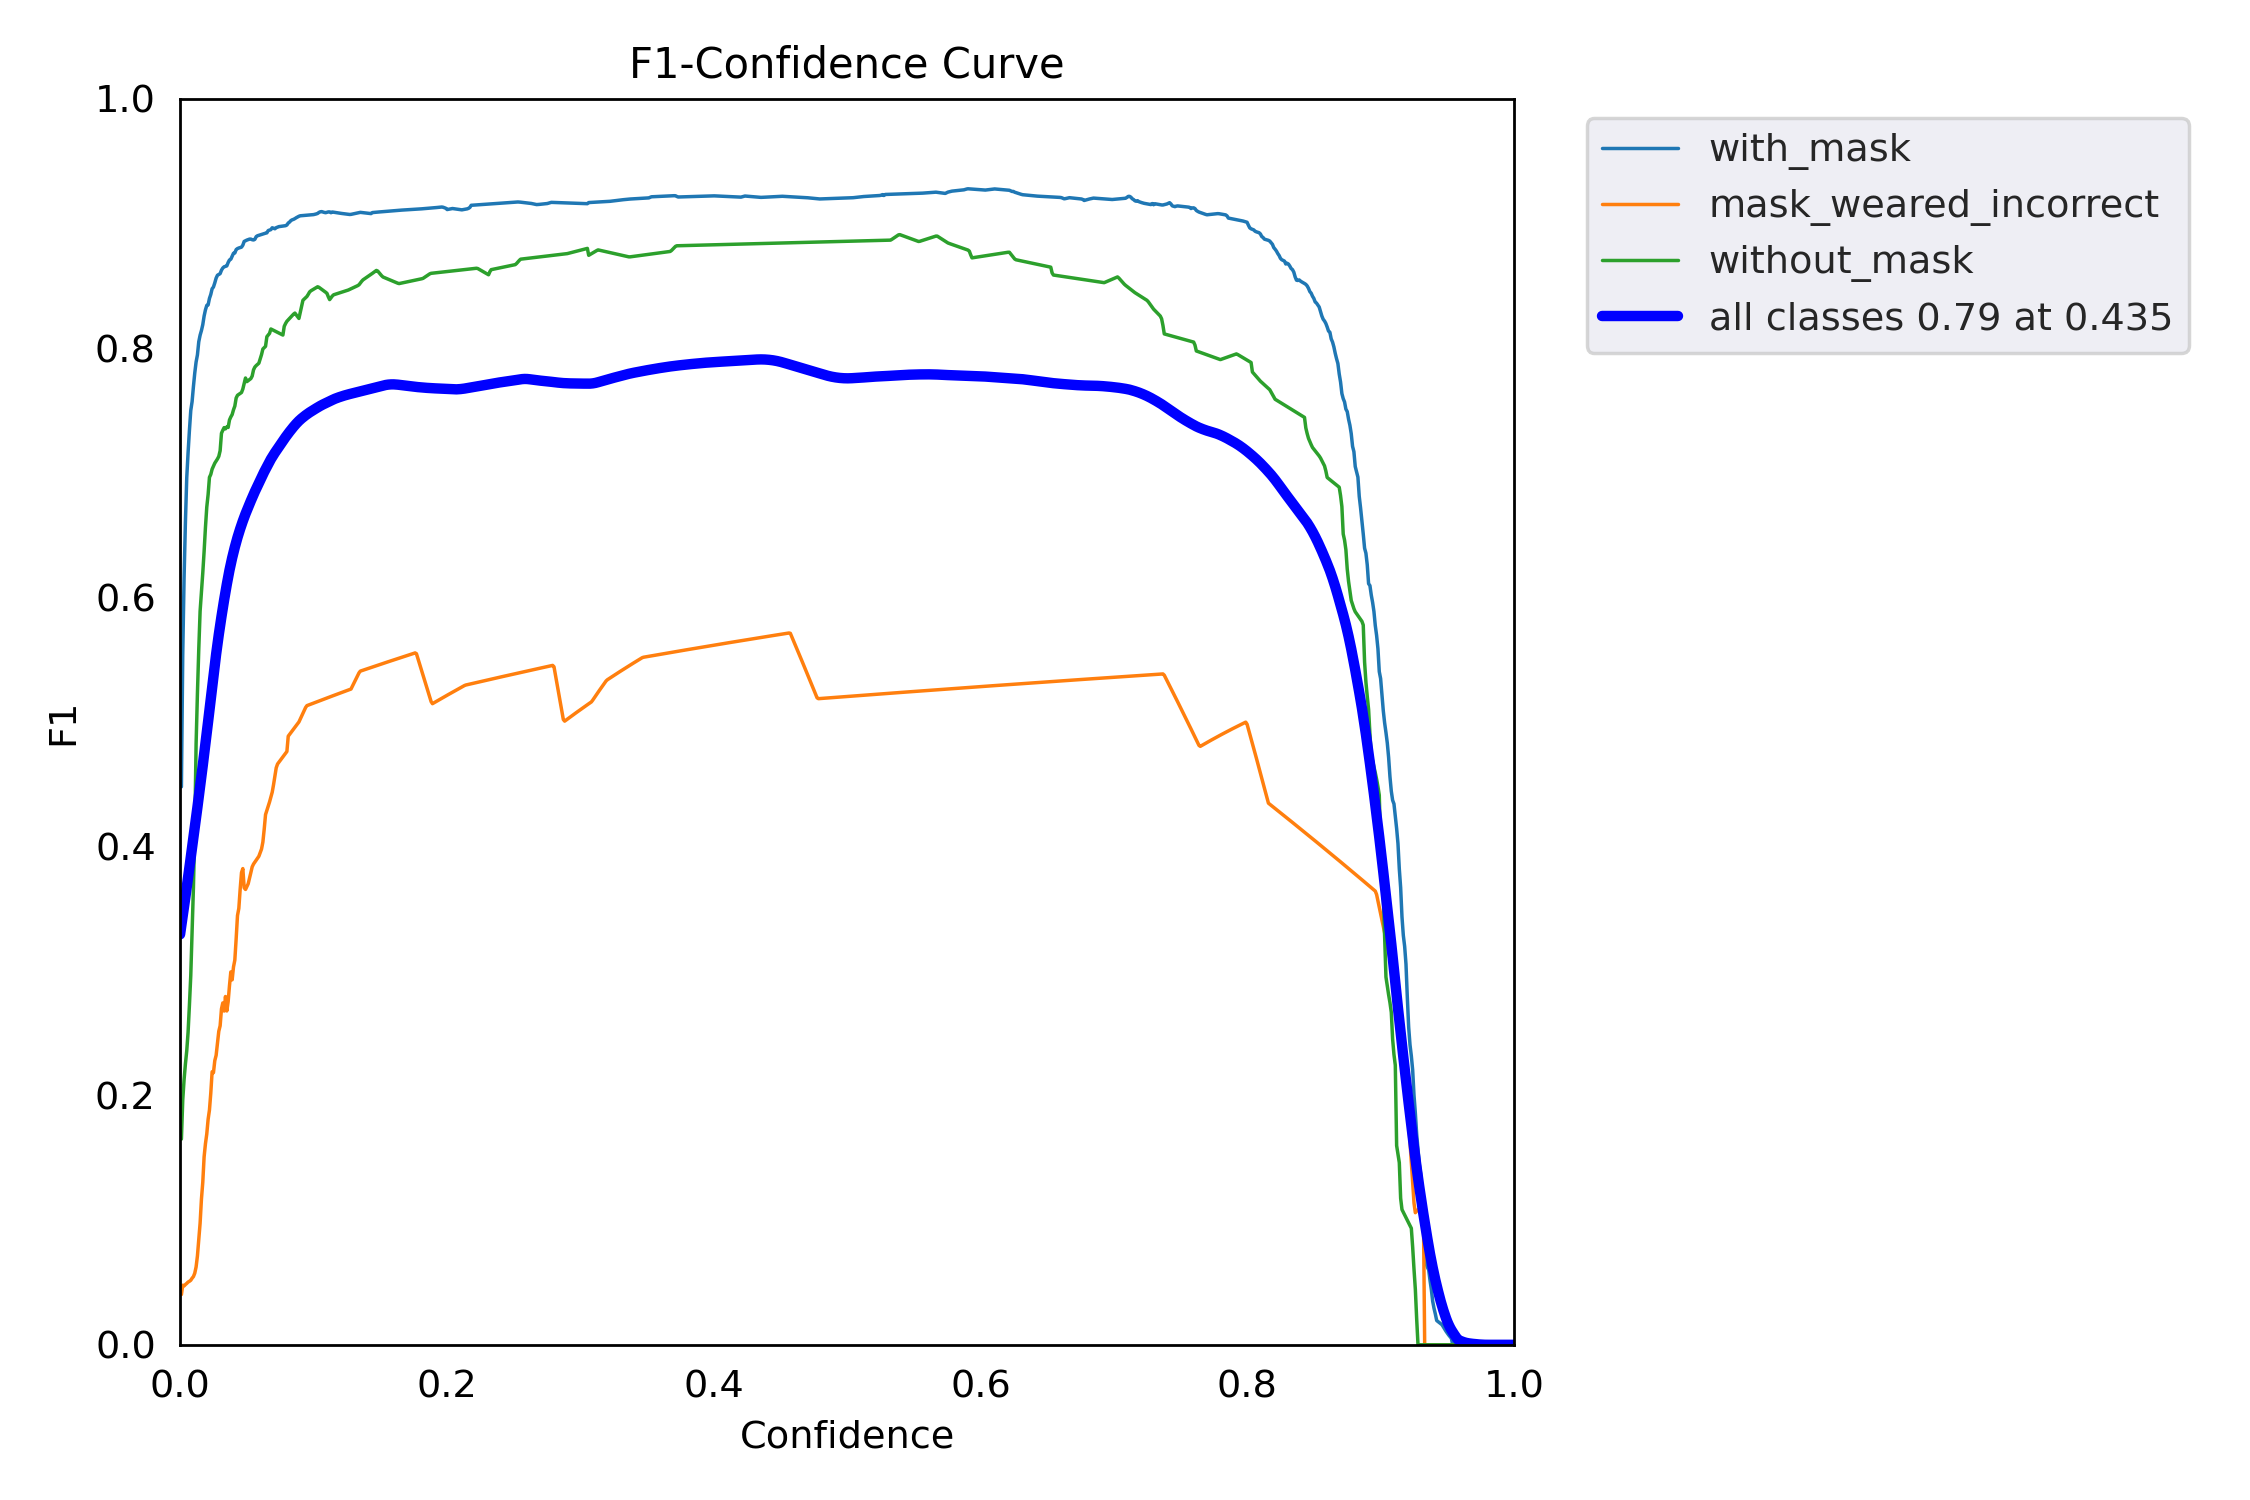

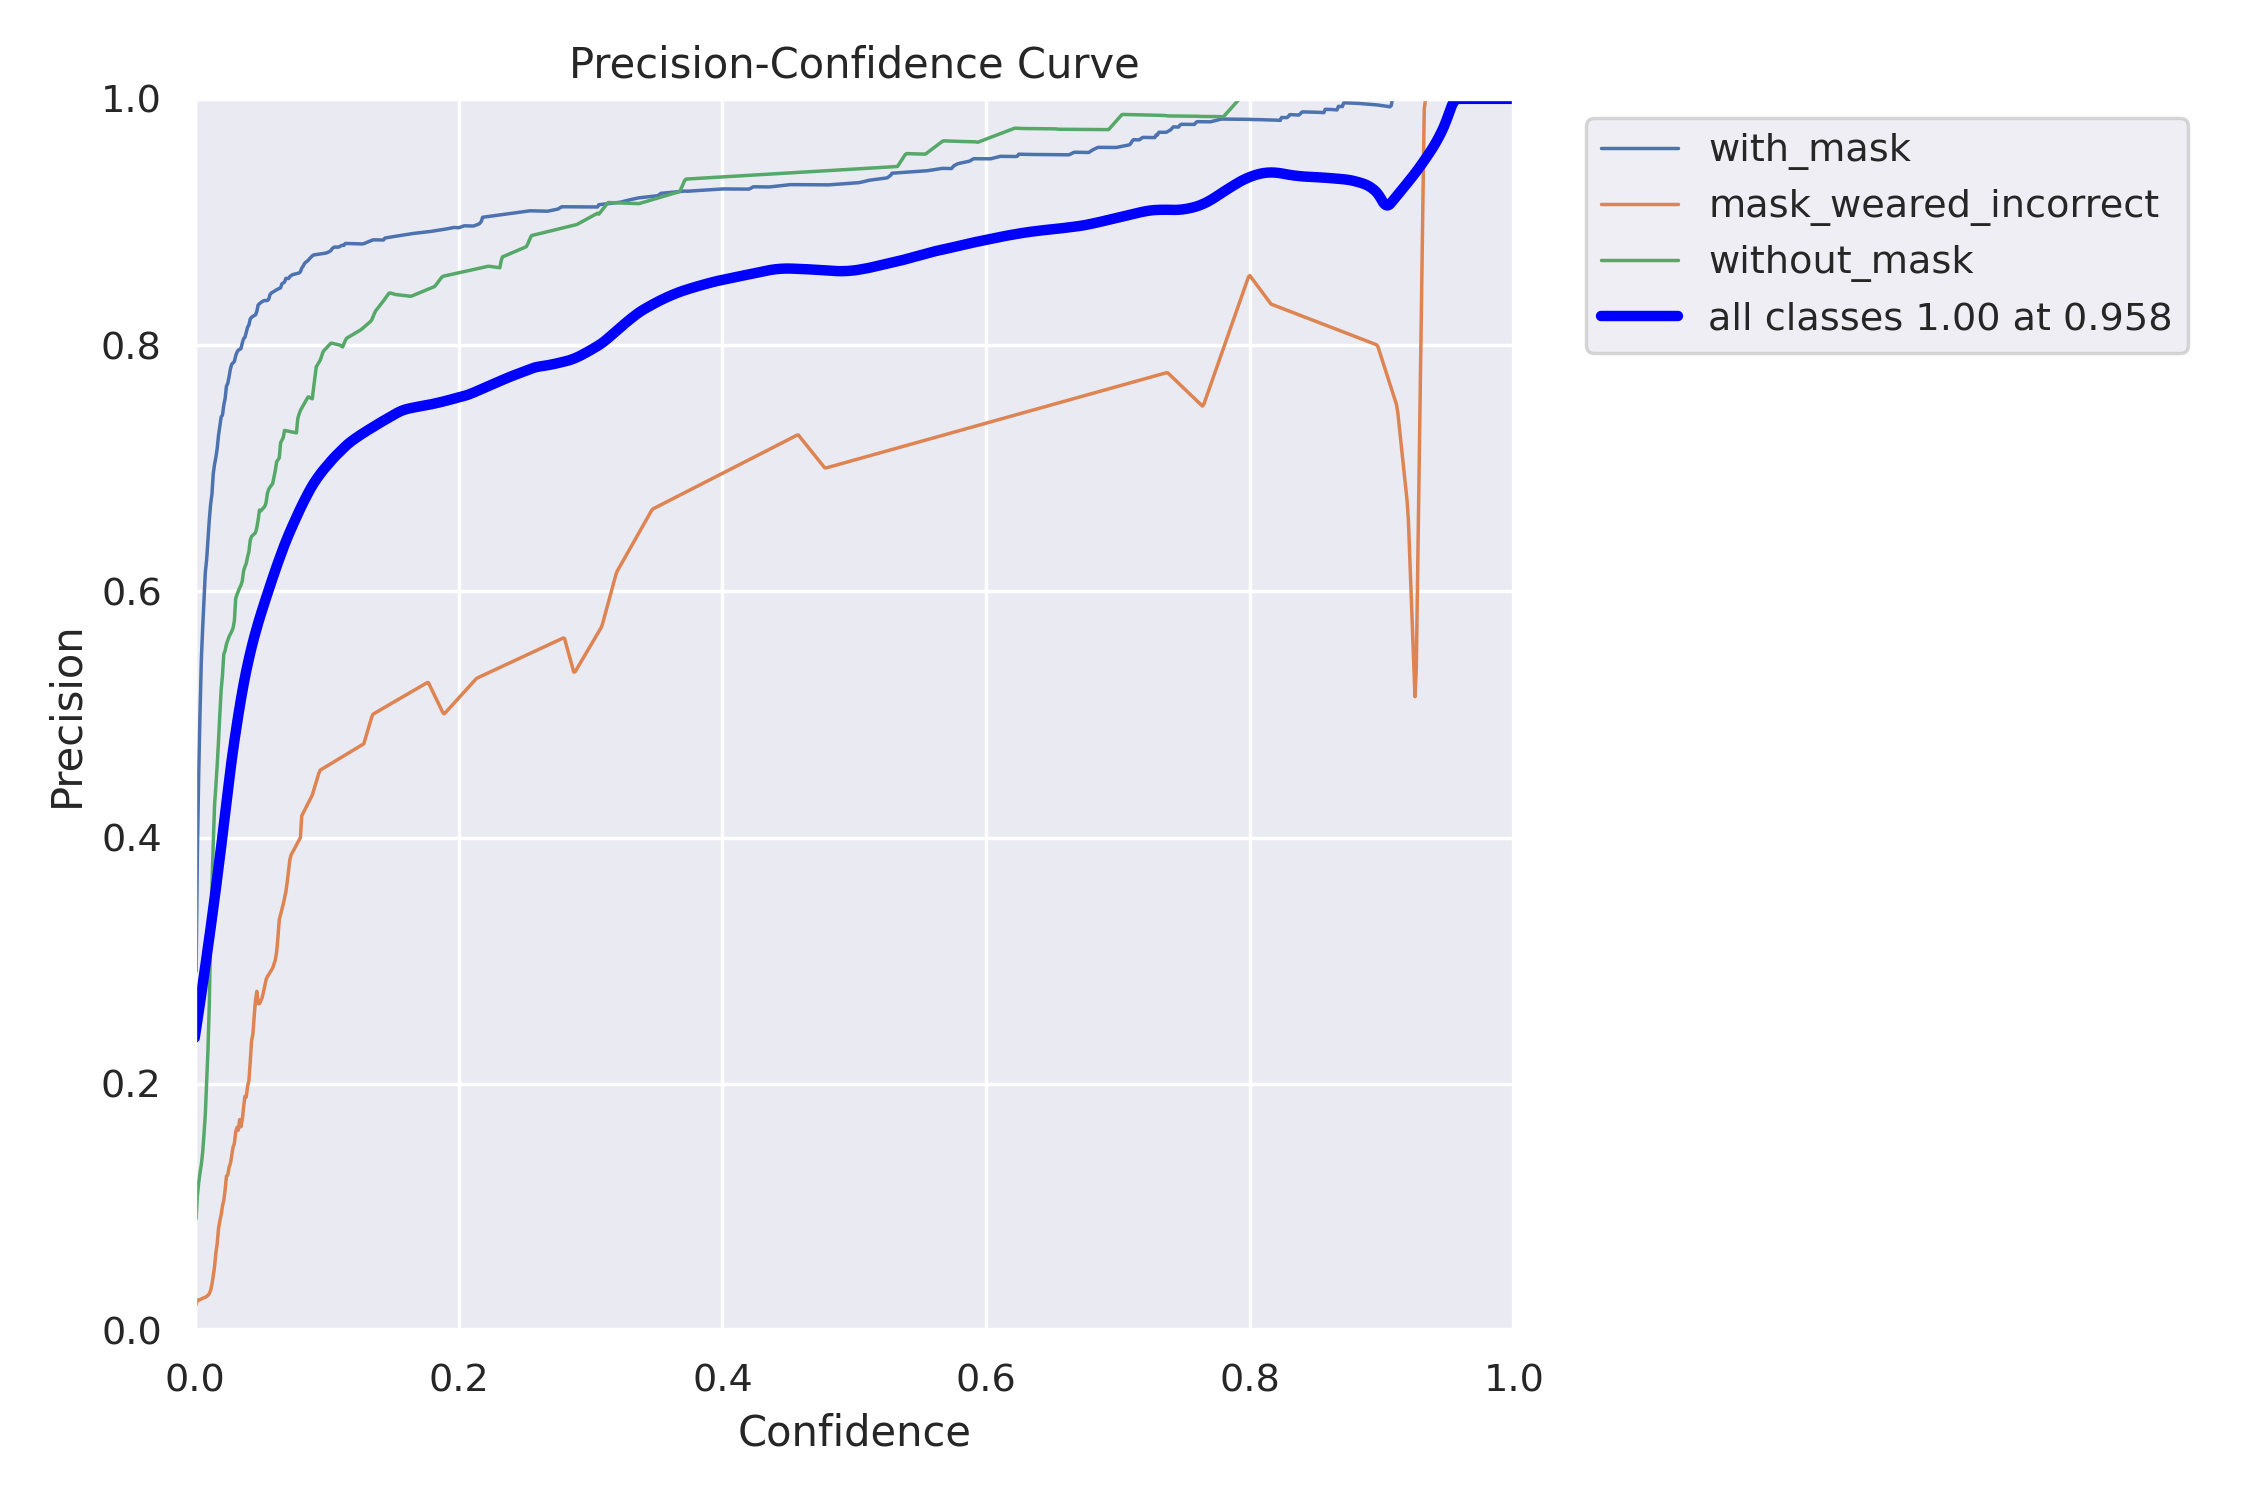

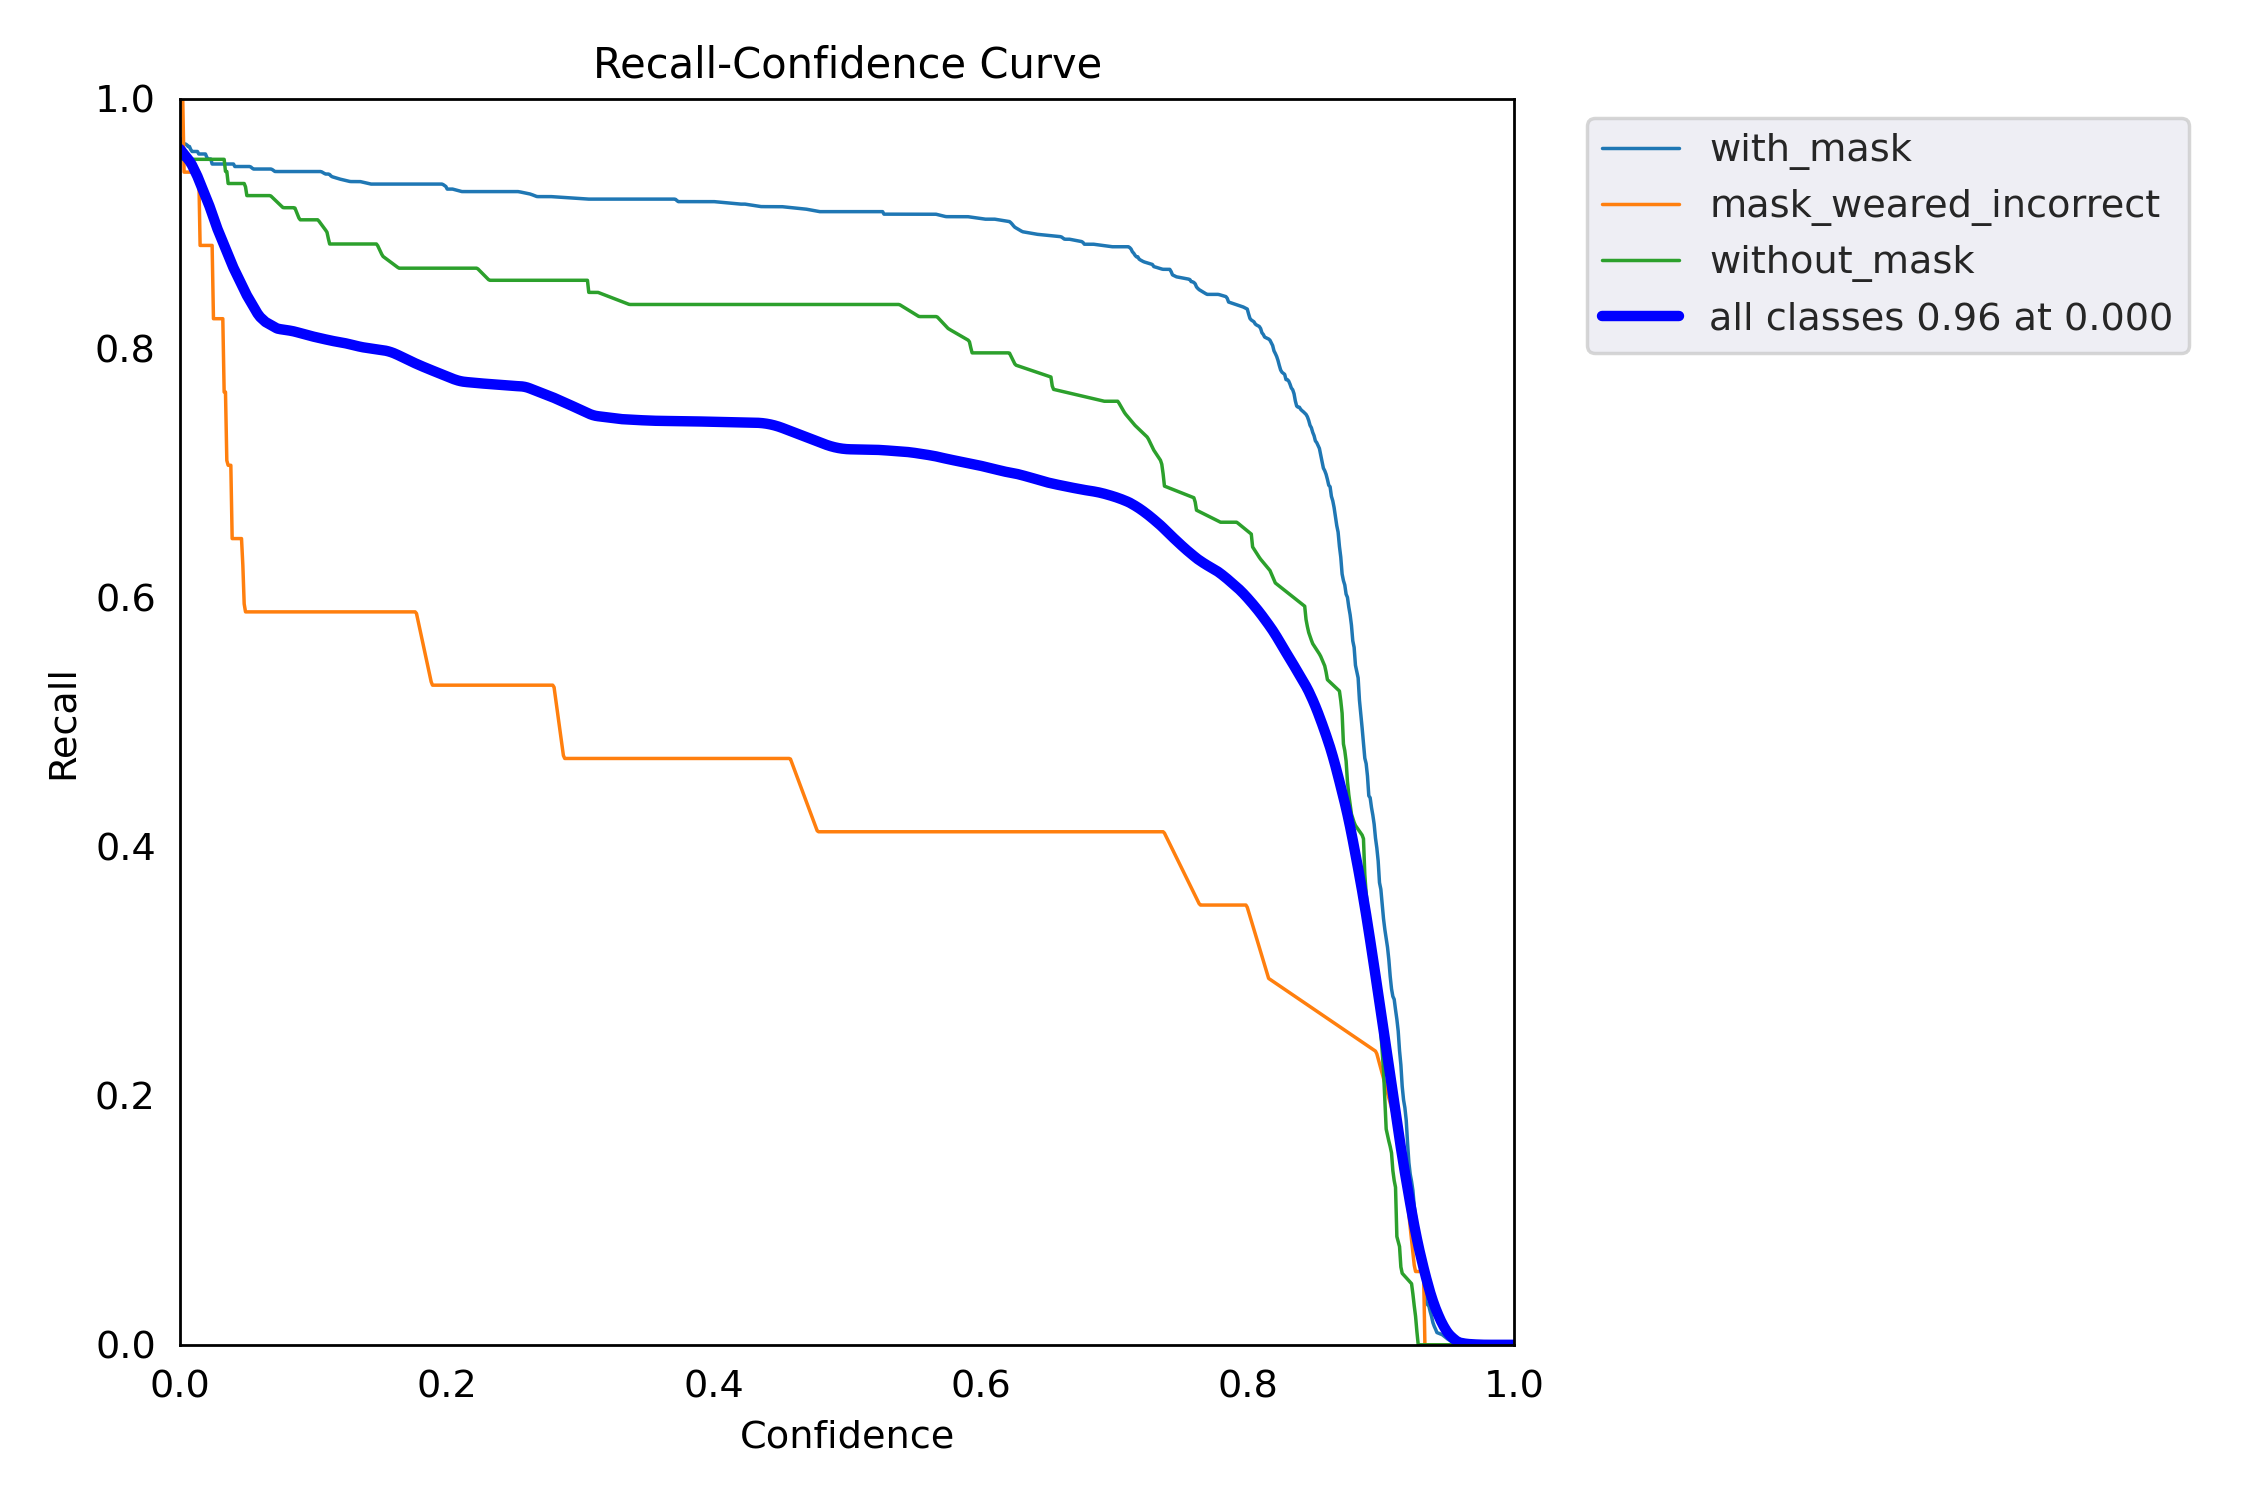

In [ ]:
from IPython.display import Image, display

# List of available plots
plots = [
    'confusion_matrix.png',
    'PR_curve.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png'
]

for plot in plots:
    display(Image(filename=f'runs/val/exp/{plot}'))

# Predicting the image which has mask or not or incorrect

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.jpg to test.jpg


In [ ]:
# Run detection
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source test.jpg

detect: weights=['runs/train/exp/weights/best.pt'], source=test.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/test.jpg: 480x640 1 mask_weared_incorrect, 82.6ms
Speed: 0.6ms pre-process, 82.6ms inference, 973.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


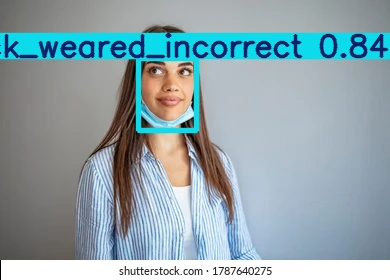

In [ ]:
from IPython.display import Image, display

# Replace 'test_image.jpg' with your image filename
display(Image(filename='runs/detect/exp/test.jpg'))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test2.jpeg to test2.jpeg


In [ ]:
# Run detection
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source test2.jpeg

detect: weights=['runs/train/exp/weights/best.pt'], source=test2.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/test2.jpeg: 384x640 1 with_mask, 60.3ms
Speed: 0.5ms pre-process, 60.3ms inference, 681.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


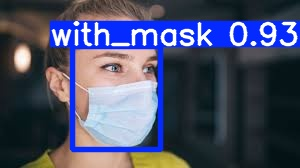

In [ ]:
from IPython.display import Image, display

# Replace 'test_image.jpg' with your image filename
display(Image(filename='runs/detect/exp3/test2.jpeg'))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test5.jpeg to test5.jpeg


In [ ]:
# Run detection
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source test5.jpeg

detect: weights=['runs/train/exp/weights/best.pt'], source=test5.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/test5.jpeg: 448x640 1 without_mask, 59.2ms
Speed: 0.5ms pre-process, 59.2ms inference, 606.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


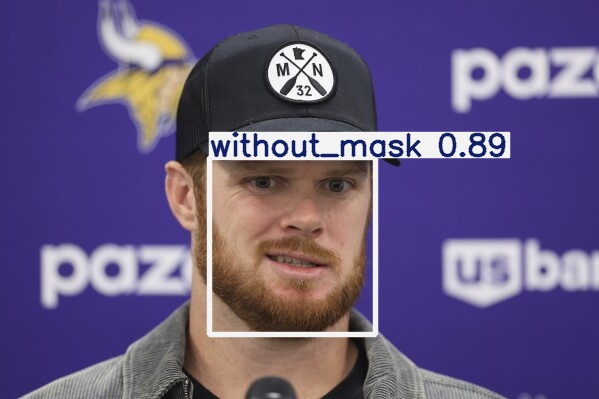

In [ ]:
from IPython.display import Image, display

# Replace 'test_image.jpg' with your image filename
display(Image(filename='runs/detect/exp4/test5.jpeg'))

In [ ]:
import torch
import cv2
from pathlib import Path

# Load the YOLOv5 model with the trained weights
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt')

# Set up class names
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']

# Define a function to add labels to each frame
def label_frame(frame, detections):
    for detection in detections:
        if len(detection) < 6:
            # Handle cases where detection does not have all six values
            print("Warning: Detection result does not contain enough values.")
            continue

        # Unpack detection
        x1, y1, x2, y2, conf, class_id = map(int, detection[:6])
        label = f"{class_names[class_id]} {conf:.2f}"

        # Draw bounding box and label
        color = (0, 255, 0) if class_id == 0 else (0, 0, 255) if class_id == 1 else (255, 0, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Process a video file
def detect_video(video_path, output_path):
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define video writer
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Process video frame-by-frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detect faces with YOLOv5
        results = model(frame)
        detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, confidence, class_id]

        # Add labels to the frame
        label_frame(frame, detections)

        # Write labeled frame to the output video
        out.write(frame)

    # Release video capture and writer
    cap.release()
    out.release()

# Paths for input video and output video
input_video_path = '/content/drive/MyDrive/Face_Mask/test.mp4'
output_video_path = '/content/drive/MyDrive/Face_Mask/output.mp4'

# Run the video detection
detect_video(input_video_path, output_video_path)

print("Video processing complete. Output saved to:", output_video_path)

Streaming output truncated to the last 5000 lines.
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/

Video processing complete. Output saved to: /content/drive/MyDrive/Face_Mask/output.mp4


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
